In [2]:
import numpy as np
from keras.applications import vgg16
from keras.preprocessing import image
from keras.activations import relu, softmax
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
# Load VGG-16 model pretrained on ImageNet dataset
model = vgg16.VGG16(weights='imagenet')

553467904/553467096 [==============================] - 16s 0us/step


40960/35363 [==================================] - 0s 4us/step
Predicted: [('n07747607', 'orange', 0.9942145), ('n07749582', 'lemon', 0.0041732057), ('n03991062', 'pot', 0.00032574168)]


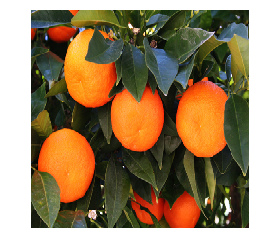

In [4]:
img_path = 'orange.jpg'
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)
plt.grid('off')
plt.axis('off')

# Create a batch and preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

# Get the initial predictions
preds = model.predict(x)
initial_class = np.argmax(preds)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

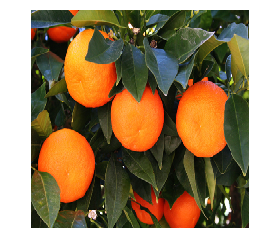

In [5]:
# Inverse of the preprocessing and plot the image
def plot_img(x):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]  
    plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
    plt.grid('off')
    plt.axis('off')
    plt.show()

# Sanity Check
plot_img(x)

In [10]:
# Get current session (assuming tf backend)
sess = K.get_session()
# Initialize adversarial example with input image
x_adv = x
# Added noise
x_noise = np.zeros_like(x)

0 4.3977878e-05 [('n07747607', 'orange', 0.9937941), ('n07749582', 'lemon', 0.004401493), ('n03991062', 'pot', 0.00035904808)]
20 0.00082135724 [('n07747607', 'orange', 0.974281), ('n07749582', 'lemon', 0.011465261), ('n03991062', 'pot', 0.0020506955)]
40 0.0082914 [('n07747607', 'orange', 0.9012804), ('n07749582', 'lemon', 0.024245316), ('n07718472', 'cucumber', 0.0082914)]
60 0.041148156 [('n07747607', 'orange', 0.71996695), ('n07718472', 'cucumber', 0.041148156), ('n07749582', 'lemon', 0.035623226)]
80 0.1031669 [('n07747607', 'orange', 0.46678492), ('n07718472', 'cucumber', 0.1031669), ('n07749582', 'lemon', 0.03712275)]
100 0.1654002 [('n07747607', 'orange', 0.27247137), ('n07718472', 'cucumber', 0.1654002), ('n07717410', 'acorn_squash', 0.049008265)]
120 0.21704683 [('n07718472', 'cucumber', 0.21704683), ('n07747607', 'orange', 0.1611568), ('n07717410', 'acorn_squash', 0.060482584)]
140 0.2550711 [('n07718472', 'cucumber', 0.2550711), ('n07747607', 'orange', 0.10305096), ('n07716

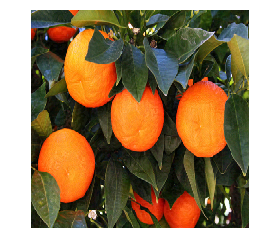

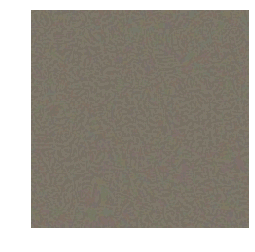

In [11]:
# Set variables
epochs = 400
epsilon = 0.01
target_class = 943 # cucumber
prev_probs = []

for i in range(epochs): 
    # One hot encode the target class
    target = K.one_hot(target_class, 1000)
    
    # Get the loss and gradient of the loss wrt the inputs
    loss = -1*K.categorical_crossentropy(target, model.output)
    grads = K.gradients(loss, model.input)

    # Get the sign of the gradient
    delta = K.sign(grads[0])
    x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon*delta

    # Get the new image and predictions
    x_adv = sess.run(x_adv, feed_dict={model.input:x})
    preds = model.predict(x_adv)

    # Store the probability of the target class
    prev_probs.append(preds[0][target_class])

    if i%20==0:
        print(i, preds[0][target_class], vgg16.decode_predictions(preds, top=3)[0])

plot_img(x_adv)
plot_img(x_adv-x)

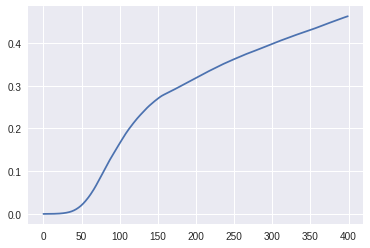

In [12]:
# Plot the probability of the target class wrt epochs
plt.plot(np.arange(0,len(prev_probs)), prev_probs)